# Part 1

Demonstrate the use of RNN, LSTM, GRU, WAVENET for a timeseries prediction task.

Ref: https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

In [ ]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

**Generate the Dataset**

In [ ]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [ ]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

-------------------

**Plot the series**

Saving figure time_series_plot


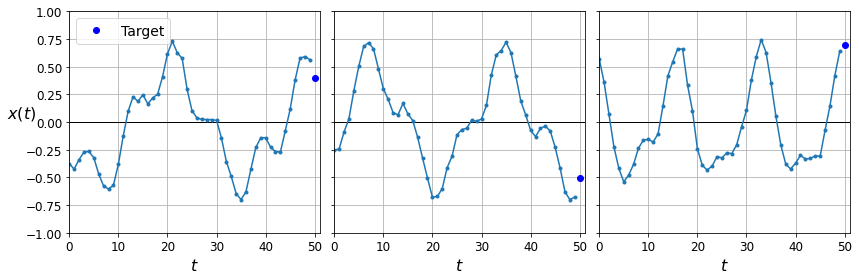

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

-------------

**RNN**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 12s 42ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 8s 34ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 8s 34ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0116 - val_l

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0109


0.010881561785936356

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

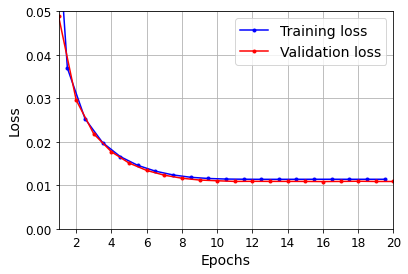

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

# Part 2

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

**one-to-one**

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# prepare sequence
length = 5
seq = np.array([i/float(length) for i in range(length)])
X = seq.reshape(len(seq), 1, 1)
y = seq.reshape(len(seq), 1)
# define LSTM configuration
n_neurons = length
n_batch = length
n_epoch = 1000
# create LSTM
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
# train LSTM
model.fit(X, y, epochs=n_epoch, batch_size=n_batch, verbose=2)
# evaluate
result = model.predict(X, batch_size=n_batch, verbose=0)
for value in result:
    print('%.1f' % value)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5)                 140       
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
1/1 - 5s - loss: 0.1961 - 5s/epoch - 5s/step
Epoch 2/1000
1/1 - 0s - loss: 0.1946 - 7ms/epoch - 7ms/step
Epoch 3/1000
1/1 - 0s - loss: 0.1931 - 7ms/epoch - 7ms/step
Epoch 4/1000
1/1 - 0s - loss: 0.1916 - 7ms/epoch - 7ms/step
Epoch 5/1000
1/1 - 0s - loss: 0.1901 - 6ms/epoch - 6ms/step
Epoch 6/1000
1/1 - 0s - loss: 0.1886 - 7ms/epoch - 7ms/step
Epoch 7/1000
1/1 - 0s - loss: 0.1872 - 7ms/epoch - 7ms/step
Epoch 8/1000
1/1 - 0s - loss:

**one to many**

In [20]:
from keras.layers import RepeatVector

In [21]:
def test_one_to_many(self):
        params = dict(
            input_dims=[1, 10], activation='tanh',
            return_sequences=False, output_dim=3
        ),
        number_of_times = 4
        model = Sequential()
        model.add(RepeatVector(number_of_times, input_shape=(10,)))

        model.add(LSTM(output_dim=params[0]['output_dim'],
                       activation=params[0]['activation'],
                       inner_activation='sigmoid',
                       return_sequences=True,
                       ))
        relative_error, keras_preds, coreml_preds = simple_model_eval(params, model)
        # print relative_error, '\n', keras_preds, '\n', coreml_preds, '\n'
        for i in range(len(relative_error)):
            self.assertLessEqual(relative_error[i], 0.01) 

In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# prepare sequence
length = 5
seq = np.array([i/float(length) for i in range(length)])
X = seq.reshape(len(seq), 1, 1)
y = seq.reshape(len(seq), 1)
# define LSTM configuration
n_neurons = length
n_batch = length
n_epoch = 1000
# create LSTM
model = Sequential()
# model.add(LSTM(n_neurons, input_shape=(1, 1)))
# model.add(Dense(1))
model.add(RepeatVector(n_neurons, input_shape=(1,)))
model.add(LSTM(1, return_sequences=True))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
# train LSTM
model.fit(X, y, epochs=n_epoch, batch_size=n_batch, verbose=2)
# evaluate
result = model.predict(X, batch_size=n_batch, verbose=0)
# for value in result:
#     print('%.1f' % value)
print(result)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 repeat_vector_6 (RepeatVect  (None, 5, 1)             0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 5, 1)              12        
                                                                 
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
1/1 - 1s - loss: 0.4070 - 1s/epoch - 1s/step
Epoch 2/1000
1/1 - 0s - loss: 0.4062 - 6ms/epoch - 6ms/step
Epoch 3/1000
1/1 - 0s - loss: 0.4053 - 6ms/epoch - 6ms/step
Epoch 4/1000
1/1 - 0s - loss: 0.4045 - 6ms/epoch - 6ms/step
Epoch 5/1000
1/1 - 0s - loss: 0.4037 - 6ms/epoch - 6ms/step
Epoch 6/1000
1/1 - 0s - loss: 0.4029 - 7ms/epoch - 7ms/step
Epoch 7/1000
1/1 - 0s - 

**many-to-one**

In [11]:
from keras.layers import Embedding

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [31]:
model = Sequential()
model.add(Embedding(5000, 32, input_length=(1)))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])        
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1, 32)             160000    
                                                                 
 lstm_7 (LSTM)               (None, 100)               53200     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
1/1 [==============================] - 4s 4s/step - loss: 0.6930 - accuracy: 0.0000e+00
Epoch 2/3
1/1 [==============================] - 0s 16ms/step - loss: 0.6922 - accuracy: 0.3333
Epoch 3/3
1/1 [==============================] - 0s 12ms/step - loss: 0.6915 - accuracy: 0.3333


**many-to-many**

In [15]:
from keras.models import Sequential
from keras.layers import *

model = Sequential()
model.add(Embedding(5000, 32, input_length=500))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 32)           160000    
                                                                 
 lstm_3 (LSTM)               (None, 100)               53200     
                                                                 
 dense_3 (Dense)             (None, 7)                 707       
                                                                 
Total params: 213,907
Trainable params: 213,907
Non-trainable params: 0
_________________________________________________________________


# Part 3

bidirectional RNN and all its features in sequential MNIST task classification

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [35]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

In [38]:
model = keras.Sequential()

model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(28, 28))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 28, 128)          47616     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 10)                650       
                                                                 
Total params: 89,482
Trainable params: 89,482
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=64, epochs=1
)

938/938 [==============================] - 17s 13ms/step - loss: 2.1443 - accuracy: 0.3033 - val_loss: 1.8325 - val_accuracy: 0.3822


# Part 4

Train a video action classifier using CNN-RNN combo (cnn for features and RNN for classification)

ref: https://keras.io/examples/vision/video_classification/

In [40]:
!pip install -q git+https://github.com/tensorflow/docs

In [41]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

In [42]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

**Define hyperparameters**

In [43]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [44]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 594
Total videos for testing: 224


,video_name,tag
336,v_Punch_g22_c06.avi,Punch
302,v_Punch_g17_c04.avi,Punch
33,v_CricketShot_g12_c06.avi,CricketShot
512,v_TennisSwing_g13_c02.avi,TennisSwing
267,v_Punch_g12_c03.avi,Punch
108,v_CricketShot_g24_c05.avi,CricketShot
353,v_Punch_g25_c02.avi,Punch
504,v_TennisSwing_g12_c01.avi,TennisSwing
311,v_Punch_g18_c06.avi,Punch
565,v_TennisSwing_g21_c02.avi,TennisSwing


In [45]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [46]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87924736/87910968 [==============================] - 1s 0us/step


In [47]:
# use the StringLookup layer encode the class labels to integers
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


In [49]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (594, 20, 2048)
Frame masks in train set: (594, 20)


**The GRU model**

In [50]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

In [51]:
# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model

In [52]:
_, sequence_model = run_experiment()

Epoch 1/10
10/13 [======================>.......] - ETA: 0s - loss: 1.5524 - accuracy: 0.3219
Epoch 1: val_loss improved from inf to 1.64717, saving model to /tmp/video_classifier
13/13 [==============================] - 9s 223ms/step - loss: 1.5536 - accuracy: 0.3084 - val_loss: 1.6472 - val_accuracy: 0.0056
Epoch 2/10
 9/13 [===================>..........] - ETA: 0s - loss: 1.3769 - accuracy: 0.4028
Epoch 2: val_loss improved from 1.64717 to 1.60653, saving model to /tmp/video_classifier
13/13 [==============================] - 0s 19ms/step - loss: 1.3464 - accuracy: 0.4169 - val_loss: 1.6065 - val_accuracy: 0.0726
Epoch 3/10
10/13 [======================>.......] - ETA: 0s - loss: 1.1779 - accuracy: 0.4812
Epoch 3: val_loss improved from 1.60653 to 1.55162, saving model to /tmp/video_classifier
13/13 [==============================] - 0s 19ms/step - loss: 1.1718 - accuracy: 0.4843 - val_loss: 1.5516 - val_accuracy: 0.1899
Epoch 4/10
10/13 [======================>.......] - ETA: 0s -

**Inference**

In [53]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

In [54]:
def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

In [55]:
# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")

Test video path: v_ShavingBeard_g05_c03.avi
  ShavingBeard: 39.80%
  Punch: 38.16%
  PlayingCello: 11.50%
  TennisSwing:  6.93%
  CricketShot:  3.60%



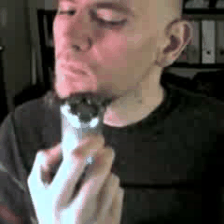

In [56]:
test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

Test video path: v_ShavingBeard_g01_c03.avi
  ShavingBeard: 34.80%
  Punch: 34.05%
  PlayingCello: 14.96%
  TennisSwing: 10.18%
  CricketShot:  6.00%



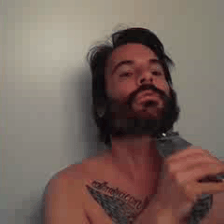

In [57]:
test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])